In [53]:
from src.mitnanex import run
import pandas as pd

In [54]:

a = run()

# I need to plot the coverage of clusters
coverages_df = pd.DataFrame(
    {
        "coverage": [i.coverage for i in a.clusters],
        "longest_read_len": [i.longest_read_length for i in a.clusters],
        "id_longest_read": [i.longest_read_id for i in a.clusters],
        "id_cluster":[i.id_cluster for i in a.clusters],
    }
)



In [55]:
# Test on the first 30 clusters
prueba = coverages_df.sort_values(by='coverage', ascending=False)
prueba.sort_values(by='id_longest_read',inplace=True)
prueba = prueba[prueba['coverage']>100]
prueba

,coverage,longest_read_len,id_longest_read,id_cluster
8,361,3121,SRR16599377.10185097,9
0,862,6183,SRR16599377.10193308,1
1,128,5330,SRR16599377.1439040,2
6,342,3382,SRR16599377.1475989,7
70,132,1637,SRR16599377.169303,71
24,223,2200,SRR16599377.2307139,25
22,372,2233,SRR16599377.2729062,23
47,182,1759,SRR16599377.3051716,48
14,538,2673,SRR16599377.3533772,15
15,705,2463,SRR16599377.4164017,16


# Oligo composition

Once I've detected the clusters with higher coverage, which I expect includes mitochondria and contamination, whether nuclear or external, I have to purify these groups. To do this I will use the oligo composition as it is used during metagenomics binning.

I will create a script to get the kmers. The kmer size will be 3 to solve two things: 1. Intrinsec error from Nanopore, 2 smaller set as possible (4**3 possible kmers). 

Finally, I will reduce dimensionality using PCA

In [56]:
from src.utils import get_sequences_by_id
from src.kmer_cnt import count_kmer

In [57]:
fasta = 'test/aedes_vexans_all_reads_subsample_sorted_length.fasta'
repr_reads = [i for i in prueba['id_longest_read']]
hist = list()
for i in get_sequences_by_id(fasta, repr_reads):
    ids, seq = i
    hist.append([*count_kmer(3,seq).values(),ids])

In [58]:
hist_df= pd.DataFrame(hist).sort_values(by=32)

In [59]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

In [60]:
pca = PCA(n_components=2)
pca.fit(hist_df.iloc[:,:-1])

PCA(n_components=2)

In [61]:
#pca.explained_variance_
#pca.components_

In [62]:
kmer_reduction = pca.fit_transform(hist_df.iloc[:,:-1])
len(kmer_reduction)

17

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


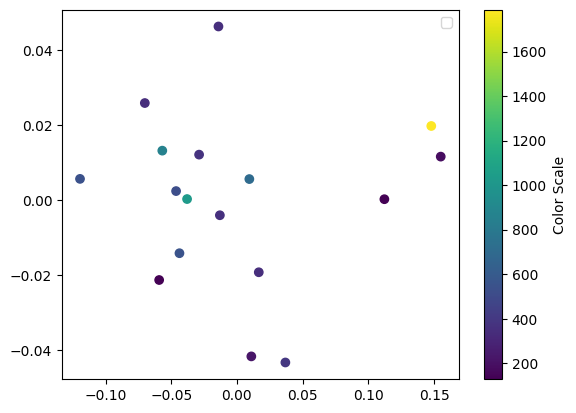

In [63]:
sc = plt.scatter(kmer_reduction[:,0],kmer_reduction[:,1], c=prueba["coverage"])
# legend
# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Color Scale')
plt.legend()